# Shakespeare Poetry Generator (NLP)


Goal:

Create a model that will predict the next word in a text sequence and train it using a corpus of Shakespeare's sonnets.

For this project, I used the [Shakespeare Sonnets Dataset](https://www.opensourceshakespeare.org/views/sonnets/sonnet_view.php?range=viewrange&sonnetrange1=1&sonnetrange2=154), which contains more than 2000 lines of text extracted from Shakespeare's sonnets.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

In [2]:
# sonnets.txt
!gdown 108jAePKK4R3BVYBbYJZ32JWUwxeMg20K

Downloading...
From: https://drive.google.com/uc?id=108jAePKK4R3BVYBbYJZ32JWUwxeMg20K
To: /content/sonnets.txt
100% 93.6k/93.6k [00:00<00:00, 7.05MB/s]


In [3]:
# Define path for file with sonnets
SONNETS_FILE = './sonnets.txt'

# Read the data
with open('./sonnets.txt') as f:
    data = f.read()

# Convert to lower case and save as a list
corpus = data.lower().split("\n")

print(f"There are {len(corpus)} lines of sonnets\n")
print(f"The first 5 lines:\n")
for i in range(5):
  print(corpus[i])

There are 2159 lines of sonnets

The first 5 lines:

from fairest creatures we desire increase,
that thereby beauty's rose might never die,
but as the riper should by time decease,
his tender heir might bear his memory:
but thou, contracted to thine own bright eyes,


## Tokenizing the text


In [4]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

In [5]:
corpus[0]

'from fairest creatures we desire increase,'

In [6]:
# texts_to_sequences expects a list
tokenizer.texts_to_sequences([corpus[0]])[0]

[34, 417, 877, 166, 213, 517]

## Generating n_grams

This function receives the fitted tokenizer and the corpus (which is a list of strings) and returns a list containing the `n_gram` sequences for each line in the corpus:

In [7]:
# grader-required-cell

# GRADED FUNCTION: n_gram_seqs
def n_gram_seqs(corpus, tokenizer):
    """
    Generates a list of n-gram sequences

    Args:
        corpus (list of string): lines of texts to generate n-grams for
        tokenizer (object): an instance of the Tokenizer class containing the word-index dictionary

    Returns:
        input_sequences (list of int): the n-gram sequences for each line in the corpus
    """
    input_sequences = []

    # Loop over every line
    for line in corpus:

      # Tokenize the current line
      token_list = tokenizer.texts_to_sequences([line])[0]

      # Loop over the line several times to generate the subphrases
      for i in range(1, len(token_list)):
        # Generate the subphrase
        n_gram_sequence = token_list[:i+1]

        # Append the subphrase to the sequences list
        input_sequences.append(n_gram_sequence)

    return input_sequences

In [8]:
# Test 1 for n_gram_seqs function
first_example_sequence = n_gram_seqs([corpus[0]], tokenizer)

print("n_gram sequences for first example look like this:\n")
first_example_sequence

n_gram sequences for first example look like this:



[[34, 417],
 [34, 417, 877],
 [34, 417, 877, 166],
 [34, 417, 877, 166, 213],
 [34, 417, 877, 166, 213, 517]]

In [9]:
# Test 2 for n_gram_seqs function
next_3_examples_sequence = n_gram_seqs(corpus[1:4], tokenizer)

print("n_gram sequences for next 3 examples look like this:\n")
next_3_examples_sequence

n_gram sequences for next 3 examples look like this:



[[8, 878],
 [8, 878, 134],
 [8, 878, 134, 351],
 [8, 878, 134, 351, 102],
 [8, 878, 134, 351, 102, 156],
 [8, 878, 134, 351, 102, 156, 199],
 [16, 22],
 [16, 22, 2],
 [16, 22, 2, 879],
 [16, 22, 2, 879, 61],
 [16, 22, 2, 879, 61, 30],
 [16, 22, 2, 879, 61, 30, 48],
 [16, 22, 2, 879, 61, 30, 48, 634],
 [25, 311],
 [25, 311, 635],
 [25, 311, 635, 102],
 [25, 311, 635, 102, 200],
 [25, 311, 635, 102, 200, 25],
 [25, 311, 635, 102, 200, 25, 278]]

Applying the `n_gram_seqs` transformation to the whole corpus and saving the maximum sequence length to use it later:

In [10]:
# Apply the n_gram_seqs transformation to the whole corpus
input_sequences = n_gram_seqs(corpus, tokenizer)

# Save max length
max_sequence_len = max([len(x) for x in input_sequences])

print(f"n_grams of input_sequences have length: {len(input_sequences)}")
print(f"maximum length of sequences is: {max_sequence_len}")

n_grams of input_sequences have length: 15462
maximum length of sequences is: 11


## Add padding to the sequences

pad_seqs` function receives a list of sequences and should return a numpy array with the padded sequences:

In [11]:
def pad_seqs(input_sequences, maxlen):
    """
    Pads tokenized sequences to the same length

    Args:
        input_sequences (list of int): tokenized sequences to pad
        maxlen (int): maximum length of the token sequences

    Returns:
        padded_sequences (array of int): tokenized sequences padded to the same length
    """
    padded_sequences = pad_sequences(input_sequences, maxlen=maxlen, padding='pre')

    return padded_sequences

In [12]:
# Test 1 for pad_seqs function
first_padded_seq = pad_seqs(first_example_sequence, max([len(x) for x in first_example_sequence]))
first_padded_seq

array([[  0,   0,   0,   0,  34, 417],
       [  0,   0,   0,  34, 417, 877],
       [  0,   0,  34, 417, 877, 166],
       [  0,  34, 417, 877, 166, 213],
       [ 34, 417, 877, 166, 213, 517]], dtype=int32)

In [13]:
# Test 2 for pad_seqs function
next_3_padded_seq = pad_seqs(next_3_examples_sequence, max([len(s) for s in next_3_examples_sequence]))
next_3_padded_seq

array([[  0,   0,   0,   0,   0,   0,   8, 878],
       [  0,   0,   0,   0,   0,   8, 878, 134],
       [  0,   0,   0,   0,   8, 878, 134, 351],
       [  0,   0,   0,   8, 878, 134, 351, 102],
       [  0,   0,   8, 878, 134, 351, 102, 156],
       [  0,   8, 878, 134, 351, 102, 156, 199],
       [  0,   0,   0,   0,   0,   0,  16,  22],
       [  0,   0,   0,   0,   0,  16,  22,   2],
       [  0,   0,   0,   0,  16,  22,   2, 879],
       [  0,   0,   0,  16,  22,   2, 879,  61],
       [  0,   0,  16,  22,   2, 879,  61,  30],
       [  0,  16,  22,   2, 879,  61,  30,  48],
       [ 16,  22,   2, 879,  61,  30,  48, 634],
       [  0,   0,   0,   0,   0,   0,  25, 311],
       [  0,   0,   0,   0,   0,  25, 311, 635],
       [  0,   0,   0,   0,  25, 311, 635, 102],
       [  0,   0,   0,  25, 311, 635, 102, 200],
       [  0,   0,  25, 311, 635, 102, 200,  25],
       [  0,  25, 311, 635, 102, 200,  25, 278]], dtype=int32)

In [14]:
# Pad the whole corpus
input_sequences = pad_seqs(input_sequences, max_sequence_len)

print(f"padded corpus has shape: {input_sequences.shape}")

padded corpus has shape: (15462, 11)


## Split the data into features and labels

The features will be the padded n_gram sequences with the last word removed from them and the labels will be the removed word.

`features_and_labels` expects the padded n_gram sequences as input and should returns a tuple containing the features and the one hot encoded labels.


In [15]:
def features_and_labels(input_sequences, total_words):
    """
    Generates features and labels from n-grams

    Args:
        input_sequences (list of int): sequences to split features and labels from
        total_words (int): vocabulary size

    Returns:
        features, one_hot_labels (array of int, array of int): arrays of features and one-hot encoded labels
    """
    features = input_sequences[:,:-1]
    labels = input_sequences[:,-1]
    one_hot_labels = to_categorical(labels, num_classes=total_words)

    return features, one_hot_labels

In [16]:
# Test your function with the padded n_grams_seq of the first example
first_features, first_labels = features_and_labels(first_padded_seq, total_words)

print(f"labels have shape: {first_labels.shape}")
print("\nfeatures look like this:\n")
first_features

labels have shape: (5, 3211)

features look like this:



array([[  0,   0,   0,   0,  34],
       [  0,   0,   0,  34, 417],
       [  0,   0,  34, 417, 877],
       [  0,  34, 417, 877, 166],
       [ 34, 417, 877, 166, 213]], dtype=int32)

In [17]:
# Split the whole corpus
features, labels = features_and_labels(input_sequences, total_words)

print(f"features have shape: {features.shape}")
print(f"labels have shape: {labels.shape}")

features have shape: (15462, 10)
labels have shape: (15462, 3211)


## Create the model

In [26]:
def create_model(total_words, max_sequence_len):
    """
    Creates a text generator model

    Args:
        total_words (int): size of the vocabulary for the Embedding layer input
        max_sequence_len (int): length of the input sequences

    Returns:
        model (tf.keras Model): the text generator model
    """
    model = Sequential()
    model.add(Embedding(total_words, 100, input_length=max_sequence_len - 1))
    # model.add(Bidirectional(LSTM(50, return_sequences=True)))
    model.add(Bidirectional(LSTM(100)))
    model.add(Dense(total_words, activation='softmax'))


    # Compile the model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])


    return model

In [27]:
# Get the untrained model
model = create_model(total_words, max_sequence_len)

# Train the model
history = model.fit(features, labels, epochs=50, verbose=1)

Epoch 1/50
484/484 [==============================] - 23s 38ms/step - loss: 6.8905 - accuracy: 0.0219
Epoch 2/50
484/484 [==============================] - 19s 39ms/step - loss: 6.4506 - accuracy: 0.0307
Epoch 3/50
484/484 [==============================] - 18s 37ms/step - loss: 6.2416 - accuracy: 0.0384
Epoch 4/50
484/484 [==============================] - 22s 46ms/step - loss: 6.0037 - accuracy: 0.0486
Epoch 5/50
484/484 [==============================] - 23s 47ms/step - loss: 5.7418 - accuracy: 0.0578
Epoch 6/50
484/484 [==============================] - 19s 39ms/step - loss: 5.4682 - accuracy: 0.0671
Epoch 7/50
484/484 [==============================] - 19s 40ms/step - loss: 5.1795 - accuracy: 0.0803
Epoch 8/50
484/484 [==============================] - 20s 41ms/step - loss: 4.8840 - accuracy: 0.0990
Epoch 9/50
484/484 [==============================] - 21s 43ms/step - loss: 4.5917 - accuracy: 0.1184
Epoch 10/50
484/484 [==============================] - 18s 37ms/step - loss: 4.297

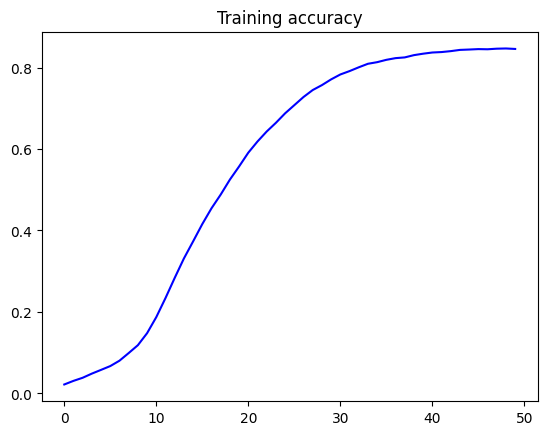

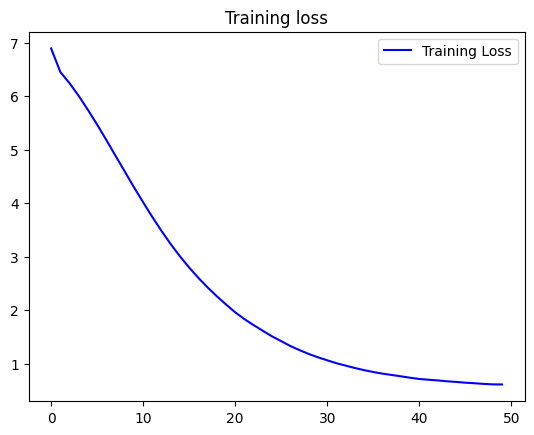

In [28]:
# Take a look at the training curves of your model

acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

## The Model in Action

Run the cell below to generate the next words of a seed text.

Try changing the seed text to see what you get!

In [29]:
seed_text = "to be or not to be"
next_words = 50

for _ in range(next_words):
    # Convert the text into sequences
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    # Pad the sequences
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    # Get the probabilities of predicting a word
    predicted = model.predict(token_list, verbose=0)
    # Choose the next word based on the maximum probability
    predicted = np.argmax(predicted, axis=-1).item()
    # Get the actual word from the word index
    output_word = tokenizer.index_word[predicted]
    # Append to the current text
    seed_text += " " + output_word

print(seed_text)


to be or not to be vile delight can prove short cold new light decrease light decrease rarities itself bastard offenders number in me shall prove new swift dispatch dispatch new back vision back vision remover doth cures be his blood and slave doth stand shows you to above the judgment part her you dwell bright


# My Findings

Each trial was done with 50 epochs.  
Tested by adding 50 additional words after seed text 'to be or not to be.'

Trial Name / Training Accuracy at Epoch 50 / Avg seconds per Epoch

##Trial 1: Shallow and Wide / ~85% / 52s
* Embedding
* Bidirectional LSTM 250
* Dense

Notes: epochs 8 - 12 had a ~10% increase with each epoch. Reached 80% at epoch 18 and stagnated at epoch 25.

*to be or not to be  
alive of me those stars rehearse now shine  
bright dead heart forth me  
now lie in me sad sun is showers new go  
shine bright highmost tomb night memory art more dead
thee me view new word  
grief thee more delight and date rhyme daily me*


## Trial 2: Deep and Narrow / ~60% / 24s
* Embedding
* Bidirectional LSTM 50
* Bidirectional LSTM 50
* Dense

Notes: 'room' gets repeated a lot the further from the seed it goes

*to be or not to be  
my love receivest not shine  
thou dumb thereby mind truth hour room grew thou  
no rehearse comment new defaced room room  
bail staineth room room room staineth  
room room bail staineth  
room room room room room pluck crime sad shade like it grace away  
tis extreme grace*  


## Trial 3: Somewhat in the Middle / ~84% / 19s
* Embedding
* Bidirectional LSTM 100
* Dense

Notes: reached 80% at epoch 33

*to be or not to be  
vile delight can prove short  
cold new light decrease light decrease rarities itself  
bastard offenders number in me shall prove new swift dispatch  
dispatch new back vision  
back vision remover doth cures  
be his blood and slave doth stand  
shows you to above the judgment  
part her you dwell bright*

